In [37]:
"""
copyright: abhirup.ghosh@gmail.com
"""

# dependencies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize
from matplotlib.gridspec import GridSpec

import matplotlib as mpl
import seaborn as sns

import matplotlib.image as mpimg

plt.style.use('ggplot')
mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams["savefig.facecolor"] = mpl.rcParams["axes.facecolor"]

from fastai.tabular.all import *

# Data

Dataset Description (from [Kaggle](https://www.kaggle.com/competitions/bike-sharing-demand/data)):

You are provided hourly rental data spanning two years. For this competition, the training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month. You must predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period.

In [38]:
df_train = pd.read_csv("./train.csv", parse_dates=['datetime'])
df_test = pd.read_csv("./test.csv", parse_dates=['datetime'])

In [39]:
df_train.info()
df_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [40]:
df_test.info()
df_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    6493 non-null   datetime64[ns]
 1   season      6493 non-null   int64         
 2   holiday     6493 non-null   int64         
 3   workingday  6493 non-null   int64         
 4   weather     6493 non-null   int64         
 5   temp        6493 non-null   float64       
 6   atemp       6493 non-null   float64       
 7   humidity    6493 non-null   int64         
 8   windspeed   6493 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(5)
memory usage: 456.7 KB


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


# EDA/Cleaning

## Datetime range

In [41]:
print(f"Training set range: {df_train.datetime.min()} -- {df_train.datetime.max()} ({df_train.datetime.max()-df_train.datetime.min()})")
print(f"Test set range: {df_test.datetime.min()} -- {df_test.datetime.max()} ({df_test.datetime.max()-df_test.datetime.min()})")

Training set range: 2011-01-01 00:00:00 -- 2012-12-19 23:00:00 (718 days 23:00:00)
Test set range: 2011-01-20 00:00:00 -- 2012-12-31 23:00:00 (711 days 23:00:00)


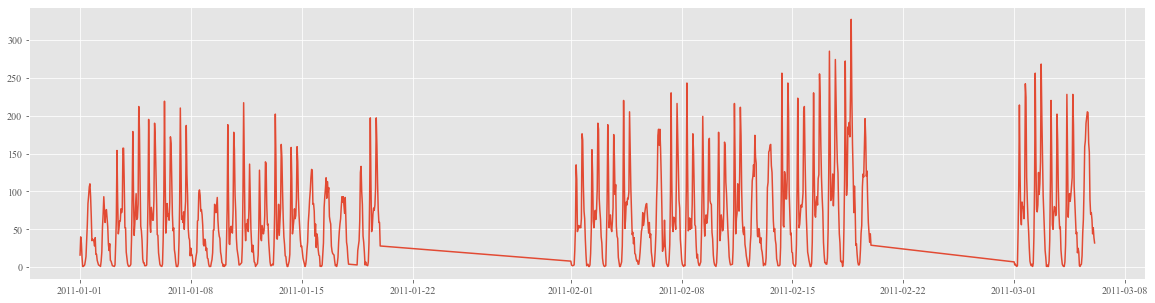

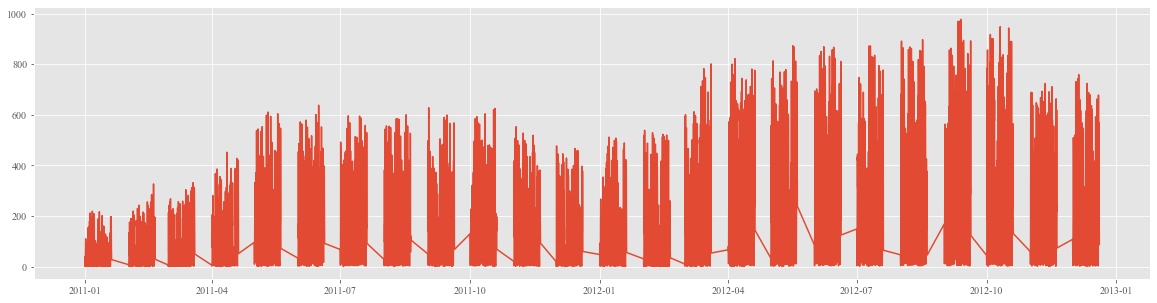

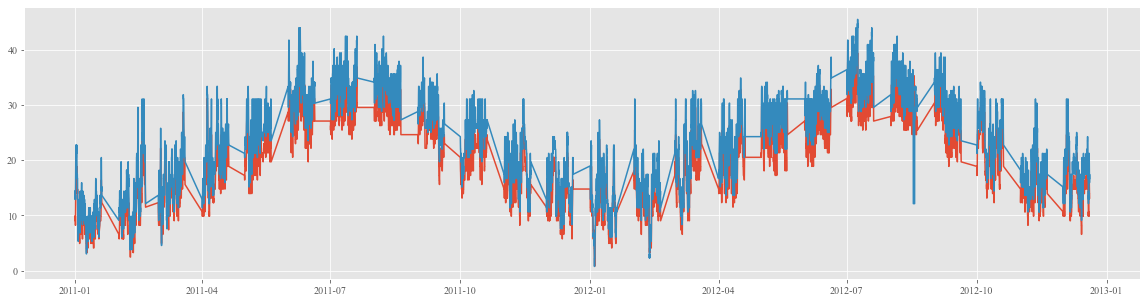

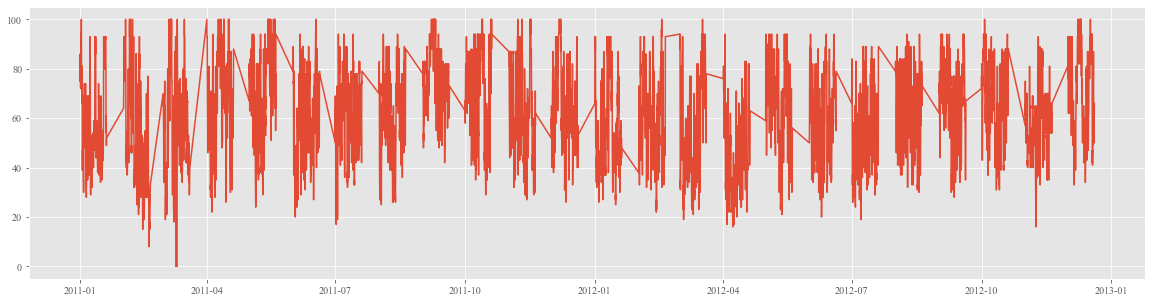

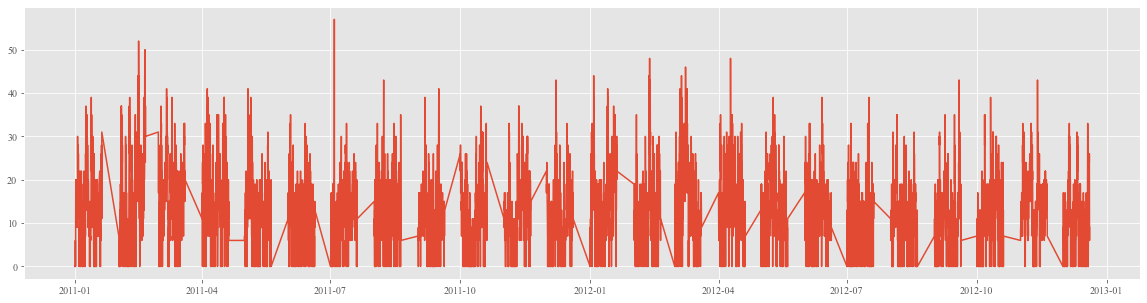

In [57]:
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(df_train['datetime'][:1000], df_train['count'][:1000])

fig, ax = plt.subplots(figsize=(20,5))
ax.plot(df_train['datetime'], df_train['count'])

fig, ax = plt.subplots(figsize=(20,5))
ax.plot(df_train['datetime'], df_train['temp'])
ax.plot(df_train['datetime'], df_train['atemp'])

fig, ax = plt.subplots(figsize=(20,5))
ax.plot(df_train['datetime'], df_train['humidity'])

fig, ax = plt.subplots(figsize=(20,5))
ax.plot(df_train['datetime'], df_train['windspeed'])

In [15]:
add_datepart(df_train, 'datetime', time=True, prefix='')
df_train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,...,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Hour,Minute,Second,Elapsed
0,1,0,0,1,9.84,14.395,81,0.0,3,13,...,False,True,False,True,False,True,0,0,0,1.293840e+09
1,1,0,0,1,9.02,13.635,80,0.0,8,32,...,False,True,False,True,False,True,1,0,0,1.293844e+09
2,1,0,0,1,9.02,13.635,80,0.0,5,27,...,False,True,False,True,False,True,2,0,0,1.293847e+09
3,1,0,0,1,9.84,14.395,75,0.0,3,10,...,False,True,False,True,False,True,3,0,0,1.293851e+09
4,1,0,0,1,9.84,14.395,75,0.0,0,1,...,False,True,False,True,False,True,4,0,0,1.293854e+09
